## Load Data

We start by loading the cleaned Uber dataset. This dataset includes key information for each trip, such as the distance traveled, the fare amount, the pickup time, and the day of the week.

In [ ]:
import pandas as pd

# Loading the dataset
df = pd.read_csv('/Users/klodje/Desktop/uber_cleaned.csv')

# Display the first few rows for accuracy
print(df.head())

       key  fare_amount            pickup_datetime  pickup_longitude  \
0  52:06.0          7.5  2015-05-07 19:52:06+00:00        -73.999817   
1  04:56.0          7.7  2009-07-17 20:04:56+00:00        -73.994355   
2  45:00.0         12.9  2009-08-24 21:45:00+00:00        -74.005043   
3  22:21.0          5.3  2009-06-26 08:22:21+00:00        -73.976124   
4  47:00.0         16.0  2014-08-28 17:47:00+00:00        -73.925023   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.738354         -73.999512         40.723217                1   
1        40.728225         -73.994710         40.750325                1   
2        40.740770         -73.962565         40.772647                1   
3        40.790844         -73.965316         40.803349                3   
4        40.744085         -73.973082         40.761247                5   

   trip_distance  pickup_hour pickup_dayofweek  
0           1.68           19         Thursday  
1           

### **Generalized Additive Models(GAMs)**

##### Before we dive into our analysis, we'll need to install the pyGAM library to model fare variation based on time. It's crucial because it handles flexible, non-linear relationships, improving our analysis.

In [ ]:
!pip install pygam

#### **Data Preparation**

##### The data reveals categorical and numerical features. We'll use LabelEncoder on categorical ones. Numerical features don't need to be encoded.
##### **NOTE**: pickup_hour, fare_amount and passegenr_count are already numerical so we will encode pickup_daofweek the only categorical feature.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, l
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Initialize LabelEncoders
le_dayofweek = LabelEncoder()

In [ ]:
# Fit and transform 'pickup_dayofweek'
df['pickup_dayofweek_encoded'] = le_dayofweek.fit_transform(df['pickup_dayofweek'])

print("\nDataFrame after Label Encoding:")
print(df.head())


DataFrame after Label Encoding:
       key  fare_amount            pickup_datetime  pickup_longitude  \
0  52:06.0          7.5  2015-05-07 19:52:06+00:00        -73.999817   
1  04:56.0          7.7  2009-07-17 20:04:56+00:00        -73.994355   
2  45:00.0         12.9  2009-08-24 21:45:00+00:00        -74.005043   
3  22:21.0          5.3  2009-06-26 08:22:21+00:00        -73.976124   
4  47:00.0         16.0  2014-08-28 17:47:00+00:00        -73.925023   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.738354         -73.999512         40.723217                1   
1        40.728225         -73.994710         40.750325                1   
2        40.740770         -73.962565         40.772647                1   
3        40.790844         -73.965316         40.803349                3   
4        40.744085         -73.973082         40.761247                5   

   trip_distance  pickup_hour pickup_dayofweek  pickup_dayofweek_encoded  
0 

##### **NOW**, We will select the relevant columns for our model including all the encoded features AND Split the data.

In [ ]:
# Selecting relevant columns
df_model = df[['fare_amount', 'pickup_hour', 'pickup_dayofweek_encoded','trip_distance','passenger_count']]

In [ ]:
# Features and target
X = df_model[['pickup_hour', 'pickup_dayofweek_encoded','trip_distance','passenger_count']].values
y = df_model['fare_amount'].values

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### 80% of the data will be use to train the model and the other 20% will be reserve to test the performance of the model.

####  **Fit GAM with Smooth Terms**

##### **s(0):** smooth term for **pickup_hour**, **s(1):** smooth term for **pickup_dayofweek_encoded**, **s(2):** smooth term for **trip_distance** and **s(3):** smooth term for **passenger_count** represent the smooth terms needed for this model.

In [ ]:
# Create and fit the Linear Regression model
gam = LinearGAM(s(0) + s(1) +l(2) +l(3))

# GridSearchCV to find optimal smoothing parameters and fits the model.
# This balances the trade-off between underfitting (too smooth) and overfitting (too wiggly), improving model accuracy.
gam.gridsearch(X_train,y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:100:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + l(2) + l(3) + intercept, tol=0.0001, 
   verbose=False)

#### **Visualize Smooth Effects**

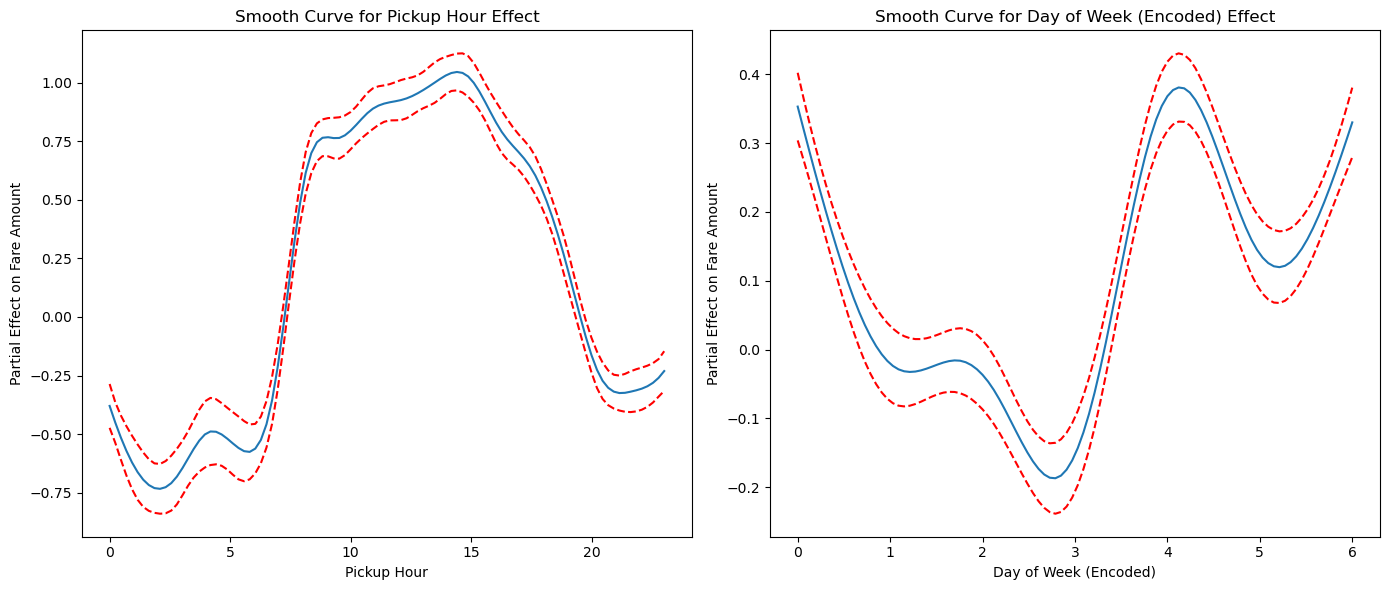

In [ ]:
feature_names = ['Pickup Hour', 'Day of Week (Encoded)']

# Adjust figure size as needed
plt.figure(figsize=(14, 6))

# Plot for pickup_hour (feature at index 0)
plt.subplot(1, 2, 1)

# Generate grid for the first feature
XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))

# 95% Confidence interval
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX, width=.95)[1], c='r', ls='--')
plt.title(f'Smooth Curve for {feature_names[0]} Effect')
plt.xlabel(feature_names[0])
plt.ylabel('Partial Effect on Fare Amount')
plt.grid(False)

# Plot for pickup_dayofweek_encoded (feature at index 1)
plt.subplot(1, 2, 2)

#Generate grid for the second feature
XX = gam.generate_X_grid(term=1)
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX))

# 95% Confidence interval
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX, width=.95)[1], c='r', ls='--')
plt.title(f'Smooth Curve for {feature_names[1]} Effect')
plt.xlabel(feature_names[1])
plt.ylabel('Partial Effect on Fare Amount')
plt.grid(False)

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

##### Fares tend to increase during peak **pickup_hour** periods, especially during morning and evening rush hours when demand is higher. Additionally, analysis of **pickup_dayofweek** shows that fare amounts are generally higher on Fridays and weekends, likely due to increased travel activity during these days.

#### **Evaluate Model Performance**

##### We will evaluate our model using Root Mean Squared Error (RMSE) and R-squared (R²) to measure prediction error and model accuracy.

In [ ]:
print("GAM Model fitted successfully!")

# Fare_amount predictions
y_pred = gam.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

GAM Model fitted successfully!
Root Mean Squared Error: 4.3236
R-squared: 0.7896


##### Our GAM model performed well, with an **R-squared** of 0.79 and an **RMSE** of 4.32, meaning it explains about 79% of fare variation and predicts fares with an average error of $4.32. This suggests it effectively captures non-linear time-based patterns in fare amounts.

In [ ]:
# We can also get a detailed summary of the model, including term effects
#print("\nGAM Model Summary:")
#gam.summary()
#print("\n---")
#print("## GAM Model Summary")
#print("---")
#print(gam.summary())

#### **Conclusions & Insights**

##### The Generalized Additive Model (GAM) model effectively uncovers complex temporal patterns in Uber fare pricing. This understanding is vital for optimizing pricing strategies, developing targeted driver incentives, and streamlining operational planning based on when demand is highest. Ultimately, both the time of day and day of the week are major drivers of fare increases during periods of elevated demand, providing critical insights for a more efficient and profitable service.